## Deploy Tar File as Endpoint

In [1]:
import sagemaker
import boto3
from sagemaker.huggingface import HuggingFace, HuggingFaceModel
import json
import base64
import io
from PIL import Image
from sagemaker.predictor import Predictor

/opt/conda/lib/python3.12/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
try:
	role = sagemaker.get_execution_role()
except ValueError:
	iam = boto3.client('iam')
	role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

In [3]:
huggingface_model = HuggingFaceModel(
    image_uri="084375588776.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-inference-extended:1.10.2-transformers4.24.0-gpu-py38-cu113-ubuntu20.04",
   model_data="s3://sagemaker-us-west-2-084375588776/VideoLLaMA3-7B/model.tar.gz",
   role=role, # iam role with permissions to create an Endpoint
   py_version="py310", # python version of the DLC
)

In [ ]:
# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
   initial_instance_count=1,
   instance_type="ml.g5.xlarge",
   container_startup_health_check_timeout=300,
)

[04/15/25 17:35:07] INFO     Creating model with name:                                              ]8;id=786858;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=610249;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\
                             huggingface-pytorch-inference-extended-2025-04-15-17-35-07-006                        

                    INFO     Creating endpoint-config with name                                     ]8;id=353273;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=363030;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             huggingface-pytorch-inference-extended-2025-04-15-17-35-07-888                        

[04/15/25 17:35:08] INFO     Creating endpoint with name                                            ]8;id=180199;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=256835;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\
                             huggingface-pytorch-inference-extended-2025-04-15-17-35-07-888                        

--------

In [5]:
s3_client = boto3.client('s3')
bucket = "perceiveaivideos"
key = "https://perceiveaivideos.s3.us-west-2.amazonaws.com/vstreamdata/plus16198551390/93A9232D-E425-4459-B258-5154CDDE0888/4D05D2FA-7C18-4837-B0E4-906839102FAC__Avocado__00000026_delta.jpg"
response = s3_client.get_object(Bucket=bucket, Key=key)
image_bytes = response['Body'].read()
image = Image.open(io.BytesIO(image_bytes))
rotated_image = image.rotate(270, expand=True)  # rotate 90 degrees clockwise
buffered = io.BytesIO()
rotated_image.save(buffered, format="JPEG")
image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

In [6]:
# image_path = "orange.png"

# # Read and encode the image to base64
# with open(image_path, "rb") as f:
#     image_bytes = f.read()
#     image_base64 = base64.b64encode(image_bytes).decode("utf-8")

obj = "avocados"

prompt = f"You are my eyes. Tell me where the {obj} are relative to my position — left, right, forward, or back."

# Construct JSON payload
data = {
    "inputs": {
        "conversation": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image", 
                        "image": {"data": image_base64}  # Send base64-encoded image data
                    },
                    {
                        "type": "text", 
                        "text": prompt
                    },
                ]
            }
        ]
    }
}

request_body = json.dumps(data)

# Set up the boto3 client to invoke the SageMaker endpoint
sagemaker_runtime = boto3.client('runtime.sagemaker')

# Go to deployments in SageMaker to see current endpoint name
endpoint_name = 'huggingface-pytorch-inference-extended-2025-04-15-17-35-07-888'



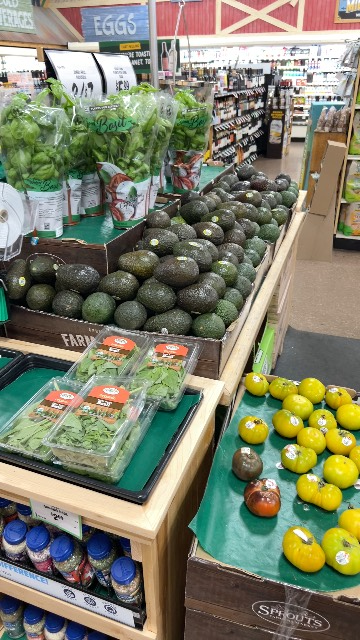

In [7]:
# from IPython.display import Image
# Image(filename='orange.png') 

rotated_image.show()


In [8]:
%%time

# Send the request to the SageMaker endpoint manually
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/json',  # Explicitly set content type
    Body=request_body
)

response_body = response['Body'].read().decode('utf-8')
print(response_body)

{"response": "The avocados are to the right of your position."}
CPU times: user 16.1 ms, sys: 3.78 ms, total: 19.9 ms
Wall time: 4.3 s


In [23]:
predictor.delete_endpoint()

[04/15/25 04:59:31] INFO     Deleting endpoint configuration with name:                             ]8;id=245227;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=637426;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4913\4913]8;;\
                             huggingface-pytorch-inference-extended-2025-04-15-04-40-33-518                        

                    INFO     Deleting endpoint with name:                                           ]8;id=628027;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=39117;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4903\4903]8;;\
                             huggingface-pytorch-inference-extended-2025-04-15-04-40-33-518                        